[Github Repository Link](https://github.com/Vasilispapg/RLAgent-RockPaperScissors)

[Colab Code Link](https://colab.research.google.com/drive/1Gf3AMGoCA3JIn-UlToRl9--7PE7ZzQAy?usp=sharing)


First, I created an Environment class(Game) that integrates an agent, specifically the RandomAgent. After that, I developed classes for both the RandomAgent and the RLAgent. 

Regarding the RL Agents, I trained numerous models using various parameters. However, all of them eventually converged to provide the same response each time.

    Note: I removed the separate train/test datasets since the filters from the Random Agent resulted in each image being unique. So, I used the same images for both training and testing.

#### Libraries

In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import gymnasium as gym
from gym import spaces
import random
from collections import deque
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

#### Labels:
* Paper: 2
* Scissor: 0
* Rock: 1

#### Load Images

In [2]:
def load_images_from_folder(folder, label, image_size=(28, 28)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, image_size)  # Resize image to match the model input
            img = img / 255.0  # Normalize image pixels to [0, 1]
            images.append(img)
            labels.append(label)
    return images, labels

img_paths={
    'rock_images':'rock',
    'scissor_images':'scissors',
    'paper_images':'paper'
}

# Load images from folders and create labels
rock_images, rock_labels = load_images_from_folder(img_paths['rock_images'], label=1)
scissor_images, scissor_labels = load_images_from_folder(img_paths['scissor_images'], label=0)
paper_images, paper_labels = load_images_from_folder(img_paths['paper_images'], label=2)

env_config = {
    'rock_images': rock_images,
    'scissor_images': scissor_images,
    'paper_images': paper_images,
}

# keep 600 images of every class for training
rock_image = rock_images[:600]
rock_label = rock_labels[:600]
scissor_image = scissor_images[:600]
scissor_label = scissor_labels[:600]
paper_image = paper_images[:600]
paper_label = paper_labels[:600]



#### Preprocess for prediction

In [4]:
def preprocess_for_prediction(image, target_size=(28, 28)):
  # Resize the image to the target size
  image = cv2.resize(image, target_size)

  # Normalize the image
  image = image / 255.0

  # Expand the dimensions to add the channel information
  image = np.expand_dims(image, axis=-1)

  return image

#### Agent

In [23]:
class Agent:
    def __init__(self, state_size=(28,28,1), action_size=3, learning_rate=0.001, discount_factor=0.95, replay_buffer_size=100, batch_size=1):
        self.state_size = state_size
        self.action_size = action_size
    

        self.budget=100

        self.total_wins = 0
        self.total_losses = 0
        self.total_draw= 0

        self.earnings_history = []

        self.memory = deque(maxlen=replay_buffer_size)
        self.batch_size = batch_size
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.model = self.create_model()
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')


    def create_model(self):

        model = Sequential([
            Conv2D(8, (3, 3), activation='sigmoid', input_shape=self.state_size),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            Conv2D(16, (3, 3), activation='sigmoid'),
            MaxPooling2D((2, 2)),
            Dropout(0.25),
            Flatten(),

            Dense(1024, activation='sigmoid'),
            Dense(1024, activation='sigmoid'),
            Dense(self.action_size, activation='softmax')  # Output action probabilities
        ])
        print(model.summary())
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        return model

    def resetScores(self):
        self.total_wins = 0
        self.total_losses = 0
        self.total_draw= 0
        self.budget=100
        self.earnings_history = []

    def choose_action(self, state):
        state = np.expand_dims(state, axis=0)
        action_probs = self.model.predict(state)[0]
        action = np.random.choice(self.action_size, p=action_probs)
        return action

    def update_budget(self,value):
      self.budget-=1
      self.budget+=value
      
      self.calculateScore(value)
      
      # Track the earnings
      self.earnings_history.append(self.budget)  
      return

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def learn(self):
        # Check if enough samples are in the memory for a minibatch
        if len(self.memory) < self.batch_size:
            return

        # Randomly sample a minibatch from the memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, targets = [], []

        # Iterate through each experience in the minibatch
        for state, action, reward, next_state, done in minibatch:
            # Initialize the target to the immediate reward
            target = reward

            # If the next state is not terminal, update the target with future discounted reward
            if not done:
                # Predict the future reward for the next state and use the maximum predicted value
                target = (reward*10 + self.discount_factor * np.amax(self.model.predict(np.expand_dims(next_state, axis=0))[0]))

            # Predict the current Q-values for the current state
            target_f = self.model.predict(np.expand_dims(state, axis=0))

            # Update the Q-value for the action taken to the newly computed target value
            target_f[0][action] = target

            # Append the state and the target to their respective lists
            states.append(state)
            targets.append(target_f[0])

        # Fit the model on the batch of states and targets
        # This step trains the neural network to better estimate Q-values
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

    def calculateScore(self,reward):
        if(reward==2):
          self.total_wins+=1
        elif reward==1:
          self.total_draw+=1
        else:
          self.total_losses+=1

    def plot_earnings(self):
        plt.plot(self.earnings_history)
        plt.title("Agent's Earnings Over Time")
        plt.xlabel("Game Rounds")
        plt.ylabel("Cumulative Earnings")
        plt.show()
        
    

#### Random Agent

In [6]:
def visualize_action_probabilities(agent, state):
    state_for_network = np.expand_dims(state, axis=0)
    action_probabilities = agent.model.predict(state_for_network)[0]
    actions = ['Scissor', 'Rock', 'Paper']
    plt.bar(actions, action_probabilities, color=['blue', 'red', 'green'])
    plt.title('Action Probabilities')
    plt.xlabel('Actions')
    plt.ylabel('Probability')
    plt.show()
    return action_probabilities


In [7]:
class RandomAgent:
    def __init__(self, env_config):
        self.rock_images = env_config['rock_images']
        self.scissor_images = env_config['scissor_images']
        self.paper_images = env_config['paper_images']


    def choose_action(self):
        image = self.select_image()
        image=preprocess_for_prediction(image)
        return [self.state,image]

    def select_image(self):
        # Select a random state (rock, paper, scissors)
        self.state = random.randint(0, 2)
        # Select a random image corresponding to the selected state
        if self.state == 1:
            self.image = random.choice(self.rock_images)
        elif self.state == 0:
            self.image = random.choice(self.scissor_images)
        else:
            self.image = random.choice(self.paper_images)
        return self.preprocess_image(self.image)

    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        # Apply vertical flip with probability p1
        if random.random() < 0.5:
            image = np.flipud(image)
        # Apply horizontal flip with probability p2
        if random.random() < 0.5:
            image = np.fliplr(image)
        # Add random noise to the image
        noise = np.random.normal(0, 0.05 * 255, image.shape)
        image = np.clip(image + noise, 0, 255)
        return image

    def preprocess_for_prediction(image, target_size=(28, 28)):
      # Resize the image to the target size
      image = cv2.resize(image, target_size)

      # Normalize the image
      image = image / 255.0

      # Expand the dimensions to add the channel information
      image = np.expand_dims(image, axis=-1)

      return image


#### Game Enviroment

In [8]:
class RockPaperScissorsEnv(gym.Env):
    def __init__(self):
        return

    def reset(self):
        return

    def step(self, action1: int, action2: int) -> tuple:
        # Define the game rules
        reward = self.game_rules(action1, action2)

        # The round ends after the agent's action
        done = True
        return (reward, done)

    def game_rules(self, state, action):
        """
        SCISSOR 0 
        PAPER = 2
        ROCK = 1
        """
        """Rock beats Scissors (1 beats 0),
          Scissors beats Paper (0 beats 2),
           Paper beats Rock (2 beats 1)
        """
        if (state == 1 and action == 0) or (state == 0 and action == 2) or (state == 2 and action == 1):
            return 0  # Agent loses
        elif state == action:
            return 1  # Draw
        else:
            return 2  # Agent wins


#### Init

In [24]:
env = RockPaperScissorsEnv()
agent=Agent()
rAgent = RandomAgent(env_config)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 13, 13, 8)         0         
 ng2D)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 13, 13, 8)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 5, 5, 16)         

#### Learn

In [10]:

import pickle
with open('new_model.pkl','rb') as f:
  agent=pickle.load(f)



1/1 [==============================] - 0s 103ms/step
Game 0, Action taken: 0, Reward: 1, Total Reward: 100
Total wins: 0, Total draw: 1, Total losses: 0
1/1 [==============================] - 0s 22ms/step
Game 1, Action taken: 0, Reward: 0, Total Reward: 99
Total wins: 0, Total draw: 1, Total losses: 1
1/1 [==============================] - 0s 21ms/step
Game 2, Action taken: 0, Reward: 1, Total Reward: 99
Total wins: 0, Total draw: 2, Total losses: 1
1/1 [==============================] - 0s 24ms/step
Game 3, Action taken: 0, Reward: 1, Total Reward: 99
Total wins: 0, Total draw: 3, Total losses: 1
1/1 [==============================] - 0s 23ms/step
Game 4, Action taken: 0, Reward: 1, Total Reward: 99
Total wins: 0, Total draw: 4, Total losses: 1
1/1 [==============================] - 0s 23ms/step
Game 5, Action taken: 0, Reward: 1, Total Reward: 99
Total wins: 0, Total draw: 5, Total losses: 1
1/1 [==============================] - 0s 22ms/step
Game 6, Action taken: 0, Reward: 1, Tota

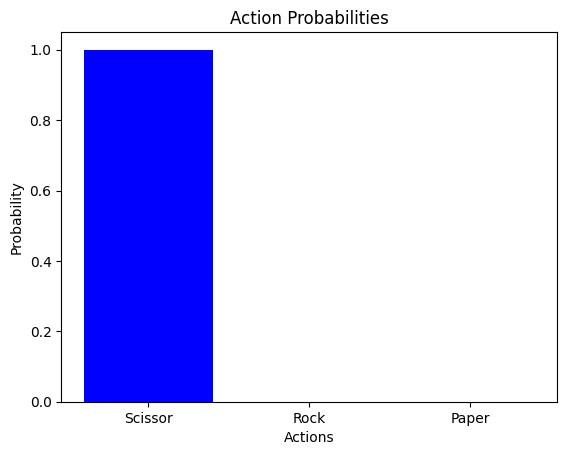

Game 100, Action taken: 0, Reward: 0, Total Reward: 94
Total wins: 29, Total draw: 37, Total losses: 35
1/1 [==============================] - 0s 23ms/step
Game 101, Action taken: 0, Reward: 1, Total Reward: 94
Total wins: 29, Total draw: 38, Total losses: 35
1/1 [==============================] - 0s 52ms/step
Game 102, Action taken: 0, Reward: 0, Total Reward: 93
Total wins: 29, Total draw: 38, Total losses: 36
1/1 [==============================] - 0s 20ms/step
Game 103, Action taken: 0, Reward: 1, Total Reward: 93
Total wins: 29, Total draw: 39, Total losses: 36
1/1 [==============================] - 0s 22ms/step
Game 104, Action taken: 0, Reward: 2, Total Reward: 94
Total wins: 30, Total draw: 39, Total losses: 36
1/1 [==============================] - 0s 22ms/step
Game 105, Action taken: 0, Reward: 2, Total Reward: 95
Total wins: 31, Total draw: 39, Total losses: 36
1/1 [==============================] - 0s 21ms/step
Game 106, Action taken: 0, Reward: 0, Total Reward: 94
Total win

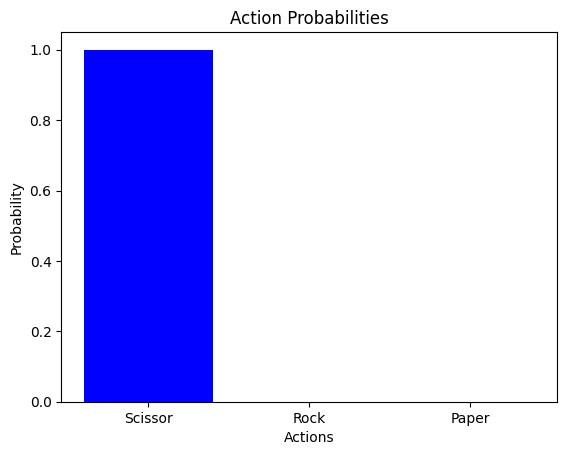

Game 200, Action taken: 0, Reward: 0, Total Reward: 107
Total wins: 69, Total draw: 70, Total losses: 62
1/1 [==============================] - 0s 26ms/step
Game 201, Action taken: 0, Reward: 1, Total Reward: 107
Total wins: 69, Total draw: 71, Total losses: 62
1/1 [==============================] - 0s 28ms/step
Game 202, Action taken: 0, Reward: 2, Total Reward: 108
Total wins: 70, Total draw: 71, Total losses: 62
1/1 [==============================] - 0s 19ms/step
Game 203, Action taken: 0, Reward: 1, Total Reward: 108
Total wins: 70, Total draw: 72, Total losses: 62
1/1 [==============================] - 0s 30ms/step
Game 204, Action taken: 0, Reward: 2, Total Reward: 109
Total wins: 71, Total draw: 72, Total losses: 62
1/1 [==============================] - 0s 22ms/step
Game 205, Action taken: 0, Reward: 2, Total Reward: 110
Total wins: 72, Total draw: 72, Total losses: 62
1/1 [==============================] - 0s 24ms/step
Game 206, Action taken: 0, Reward: 0, Total Reward: 109
To

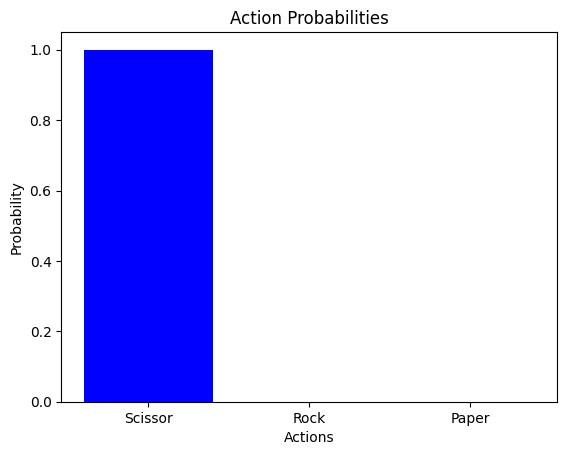

Game 300, Action taken: 0, Reward: 1, Total Reward: 113
Total wins: 103, Total draw: 108, Total losses: 90
1/1 [==============================] - 0s 22ms/step
Game 301, Action taken: 0, Reward: 1, Total Reward: 113
Total wins: 103, Total draw: 109, Total losses: 90
1/1 [==============================] - 0s 22ms/step
Game 302, Action taken: 0, Reward: 0, Total Reward: 112
Total wins: 103, Total draw: 109, Total losses: 91
1/1 [==============================] - 0s 22ms/step
Game 303, Action taken: 0, Reward: 2, Total Reward: 113
Total wins: 104, Total draw: 109, Total losses: 91
1/1 [==============================] - 0s 21ms/step
Game 304, Action taken: 0, Reward: 0, Total Reward: 112
Total wins: 104, Total draw: 109, Total losses: 92
1/1 [==============================] - 0s 22ms/step
Game 305, Action taken: 0, Reward: 2, Total Reward: 113
Total wins: 105, Total draw: 109, Total losses: 92
1/1 [==============================] - 0s 23ms/step
Game 306, Action taken: 0, Reward: 0, Total Re

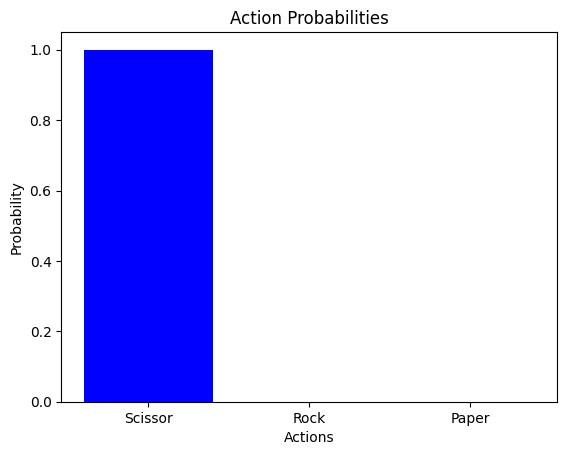

Game 400, Action taken: 0, Reward: 1, Total Reward: 104
Total wins: 135, Total draw: 135, Total losses: 131
1/1 [==============================] - 0s 19ms/step
Game 401, Action taken: 0, Reward: 0, Total Reward: 103
Total wins: 135, Total draw: 135, Total losses: 132
1/1 [==============================] - 0s 21ms/step
Game 402, Action taken: 0, Reward: 1, Total Reward: 103
Total wins: 135, Total draw: 136, Total losses: 132
1/1 [==============================] - 0s 22ms/step
Game 403, Action taken: 0, Reward: 2, Total Reward: 104
Total wins: 136, Total draw: 136, Total losses: 132
1/1 [==============================] - 0s 22ms/step
Game 404, Action taken: 0, Reward: 0, Total Reward: 103
Total wins: 136, Total draw: 136, Total losses: 133
1/1 [==============================] - 0s 20ms/step
Game 405, Action taken: 0, Reward: 2, Total Reward: 104
Total wins: 137, Total draw: 136, Total losses: 133
1/1 [==============================] - 0s 23ms/step
Game 406, Action taken: 0, Reward: 0, To

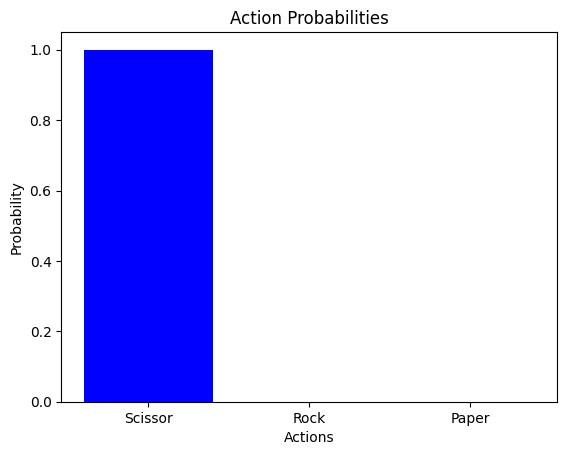

Game 500, Action taken: 0, Reward: 2, Total Reward: 107
Total wins: 165, Total draw: 178, Total losses: 158
1/1 [==============================] - 0s 21ms/step
Game 501, Action taken: 0, Reward: 2, Total Reward: 108
Total wins: 166, Total draw: 178, Total losses: 158
1/1 [==============================] - 0s 24ms/step
Game 502, Action taken: 0, Reward: 2, Total Reward: 109
Total wins: 167, Total draw: 178, Total losses: 158
1/1 [==============================] - 0s 22ms/step
Game 503, Action taken: 0, Reward: 1, Total Reward: 109
Total wins: 167, Total draw: 179, Total losses: 158
1/1 [==============================] - 0s 21ms/step
Game 504, Action taken: 0, Reward: 1, Total Reward: 109
Total wins: 167, Total draw: 180, Total losses: 158
1/1 [==============================] - 0s 22ms/step
Game 505, Action taken: 0, Reward: 1, Total Reward: 109
Total wins: 167, Total draw: 181, Total losses: 158
1/1 [==============================] - 0s 21ms/step
Game 506, Action taken: 0, Reward: 1, To

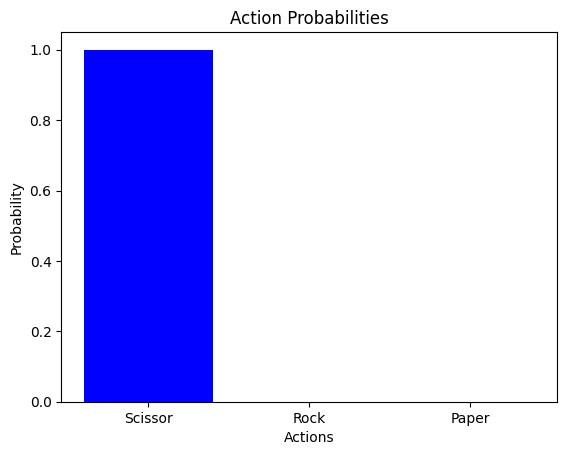

Game 600, Action taken: 0, Reward: 0, Total Reward: 105
Total wins: 195, Total draw: 216, Total losses: 190
1/1 [==============================] - 0s 21ms/step
Game 601, Action taken: 0, Reward: 2, Total Reward: 106
Total wins: 196, Total draw: 216, Total losses: 190
1/1 [==============================] - 0s 20ms/step
Game 602, Action taken: 0, Reward: 1, Total Reward: 106
Total wins: 196, Total draw: 217, Total losses: 190
1/1 [==============================] - 0s 22ms/step
Game 603, Action taken: 0, Reward: 2, Total Reward: 107
Total wins: 197, Total draw: 217, Total losses: 190
1/1 [==============================] - 0s 22ms/step
Game 604, Action taken: 0, Reward: 2, Total Reward: 108
Total wins: 198, Total draw: 217, Total losses: 190
1/1 [==============================] - 0s 22ms/step
Game 605, Action taken: 0, Reward: 1, Total Reward: 108
Total wins: 198, Total draw: 218, Total losses: 190
1/1 [==============================] - 0s 22ms/step
Game 606, Action taken: 0, Reward: 1, To

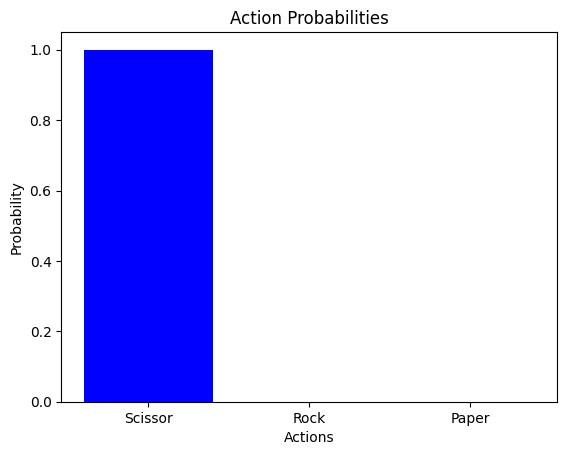

Game 700, Action taken: 0, Reward: 2, Total Reward: 100
Total wins: 227, Total draw: 247, Total losses: 227
1/1 [==============================] - 0s 22ms/step
Game 701, Action taken: 0, Reward: 0, Total Reward: 99
Total wins: 227, Total draw: 247, Total losses: 228
1/1 [==============================] - 0s 21ms/step
Game 702, Action taken: 0, Reward: 2, Total Reward: 100
Total wins: 228, Total draw: 247, Total losses: 228
1/1 [==============================] - 0s 20ms/step
Game 703, Action taken: 0, Reward: 2, Total Reward: 101
Total wins: 229, Total draw: 247, Total losses: 228
1/1 [==============================] - 0s 21ms/step
Game 704, Action taken: 0, Reward: 2, Total Reward: 102
Total wins: 230, Total draw: 247, Total losses: 228
1/1 [==============================] - 0s 21ms/step
Game 705, Action taken: 0, Reward: 2, Total Reward: 103
Total wins: 231, Total draw: 247, Total losses: 228
1/1 [==============================] - 0s 20ms/step
Game 706, Action taken: 0, Reward: 2, Tot

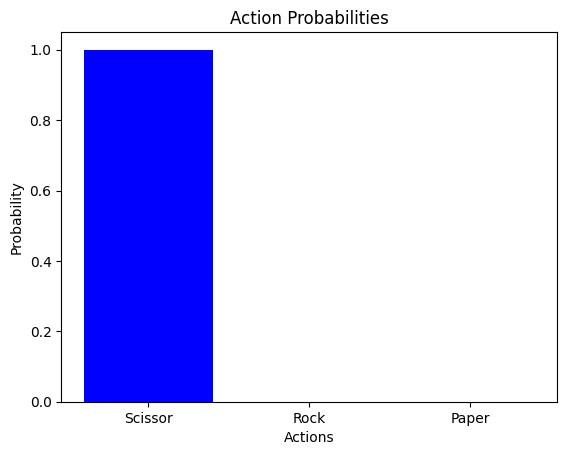

Game 800, Action taken: 0, Reward: 2, Total Reward: 101
Total wins: 260, Total draw: 282, Total losses: 259
1/1 [==============================] - 0s 19ms/step
Game 801, Action taken: 0, Reward: 1, Total Reward: 101
Total wins: 260, Total draw: 283, Total losses: 259
1/1 [==============================] - 0s 22ms/step
Game 802, Action taken: 0, Reward: 1, Total Reward: 101
Total wins: 260, Total draw: 284, Total losses: 259
1/1 [==============================] - 0s 21ms/step
Game 803, Action taken: 0, Reward: 2, Total Reward: 102
Total wins: 261, Total draw: 284, Total losses: 259
1/1 [==============================] - 0s 23ms/step
Game 804, Action taken: 0, Reward: 0, Total Reward: 101
Total wins: 261, Total draw: 284, Total losses: 260
1/1 [==============================] - 0s 22ms/step
Game 805, Action taken: 0, Reward: 2, Total Reward: 102
Total wins: 262, Total draw: 284, Total losses: 260
1/1 [==============================] - 0s 20ms/step
Game 806, Action taken: 0, Reward: 2, To

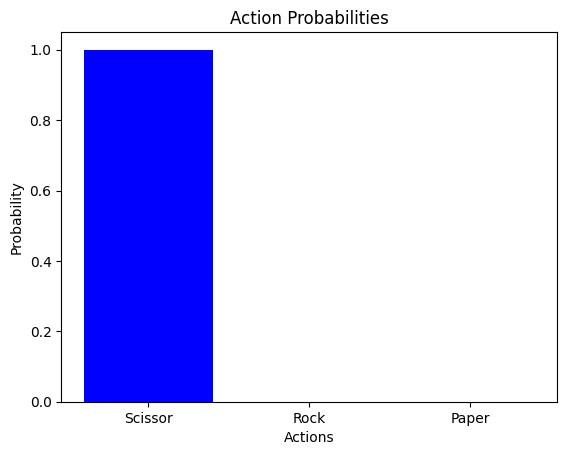

Game 900, Action taken: 0, Reward: 2, Total Reward: 100
Total wins: 295, Total draw: 311, Total losses: 295
1/1 [==============================] - 0s 21ms/step
Game 901, Action taken: 0, Reward: 1, Total Reward: 100
Total wins: 295, Total draw: 312, Total losses: 295
1/1 [==============================] - 0s 21ms/step
Game 902, Action taken: 0, Reward: 1, Total Reward: 100
Total wins: 295, Total draw: 313, Total losses: 295
1/1 [==============================] - 0s 21ms/step
Game 903, Action taken: 0, Reward: 1, Total Reward: 100
Total wins: 295, Total draw: 314, Total losses: 295
1/1 [==============================] - 0s 25ms/step
Game 904, Action taken: 0, Reward: 0, Total Reward: 99
Total wins: 295, Total draw: 314, Total losses: 296
1/1 [==============================] - 0s 22ms/step
Game 905, Action taken: 0, Reward: 0, Total Reward: 98
Total wins: 295, Total draw: 314, Total losses: 297
1/1 [==============================] - 0s 21ms/step
Game 906, Action taken: 0, Reward: 2, Tota

: 

In [25]:
num_episodes = 1000  # Set the number of games you want to play
# 5500 games learned -> 7 hours of training


# init the first state
rAction,state = rAgent.choose_action()

for e in range(num_episodes):
    done = False

    while not done:

        # get The image
        action = agent.choose_action(state)
        
         # Visualize the action probabilities
        if(e%100==0 and e!=0):
            action_probabilities = visualize_action_probabilities(agent, state)


        # get reward
        reward, done = env.step(rAction,action)

        # get next state
        next_rAction,next_state = rAgent.choose_action()

        # Store this experience
        agent.remember(state, action, reward, next_state, done)

        rAction = next_rAction
        state = next_state

        agent.update_budget(reward) # Update the budget of the agent

        print(f"Game {e}, Action taken: {action}, Reward: {reward}, Total Reward: {agent.budget}")
        print(f"Total wins: {agent.total_wins}, Total draw: {agent.total_draw}, Total losses: {agent.total_losses}")

        # Learn from the experience
        if done:
            agent.learn()



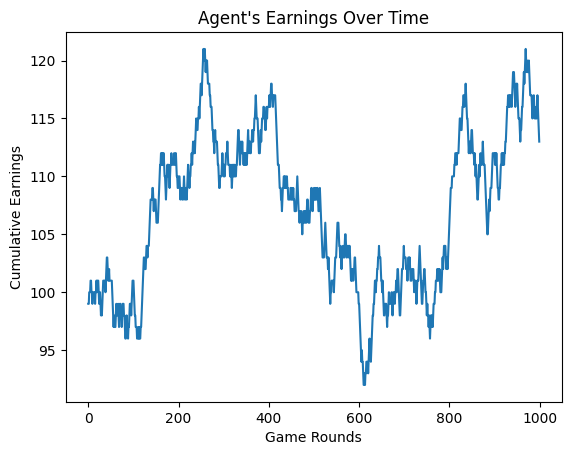

DRAW:341
LOST:323
WIN:336


In [37]:
agent.plot_earnings()
print(f'DRAW:{agent.total_draw}\nLOST:{agent.total_losses}\nWIN:{agent.total_wins}')

Previous Best RL agent

    In the end the only answer was Scissor

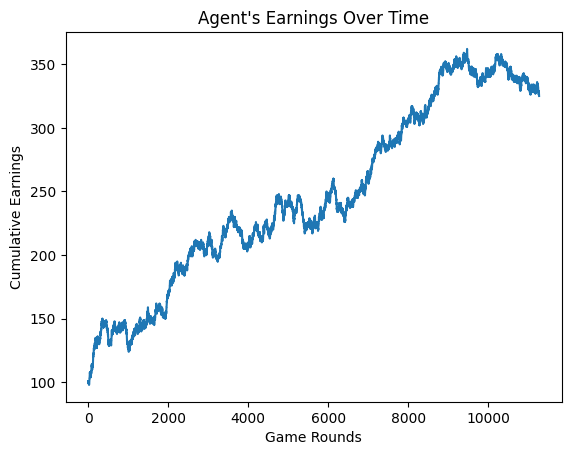

* DRAW:3746
* LOST:3653
* WIN:3878

#### Game

In [12]:
# Set the number of games you want to play_game
num_episodes =100
agent.resetScores()
episode_game=0

for e in range(num_episodes):
    episode_game+=1
    done = False

    while not done:
        rAction,state = rAgent.choose_action()

        action = agent.choose_action(state)

        reward, done = env.step(rAction,action)
        
        print("AGENT: ", end="")
        if(action==2):
            print("PAPER")
        elif action==0:
            print("SCISSOR")
        else:
            print("ROCK")
            
        print("USER:", end="")
        if(rAction==2):
            print("PAPER")
        elif rAction==0:
            print("SCISSOR")
        else:
            print("ROCK")

        agent.update_budget(reward)

        print(f"Game {episode_game}, Action taken: {action}, Reward: {reward}, Total Reward: {agent.budget}")
        print(f"Total wins: {agent.total_wins}, Total draw: {agent.total_draw}, Total losses: {agent.total_losses}")



1/1 [==============================] - 0s 31ms/step
AGENT: ROCK
USER:ROCK
Game 1, Action taken: 1, Reward: 1, Total Reward: 100
Total wins: 0, Total draw: 1, Total losses: 0
1/1 [==============================] - 0s 24ms/step
AGENT: ROCK
USER:PAPER
Game 2, Action taken: 1, Reward: 0, Total Reward: 99
Total wins: 0, Total draw: 1, Total losses: 1
1/1 [==============================] - 0s 23ms/step
AGENT: ROCK
USER:ROCK
Game 3, Action taken: 1, Reward: 1, Total Reward: 99
Total wins: 0, Total draw: 2, Total losses: 1
1/1 [==============================] - 0s 21ms/step
AGENT: ROCK
USER:SCISSOR
Game 4, Action taken: 1, Reward: 2, Total Reward: 100
Total wins: 1, Total draw: 2, Total losses: 1
1/1 [==============================] - 0s 20ms/step
AGENT: ROCK
USER:ROCK
Game 5, Action taken: 1, Reward: 1, Total Reward: 100
Total wins: 1, Total draw: 3, Total losses: 1
1/1 [==============================] - 0s 30ms/step
AGENT: ROCK
USER:ROCK
Game 6, Action taken: 1, Reward: 1, Total Reward: 100


#### Image from me

In [11]:
photo_images = ['user/paper.JPEG', 'user/rock.JPEG', 'user/scis.JPEG']

def getImages():
    images = []
    labels = []
    for filename in photo_images:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (28, 28))  # Resize image to match the model input
            img = img / 255.0  # Normalize image pixels to [0, 1]
            images.append(img)
            if filename == 'user/paper.JPEG':
                labels.append(2)
            elif filename == 'user/rock.JPEG':
                labels.append(1)
            else:
                labels.append(0)
    return images, labels

images, labels = getImages()

win = 0
draw = 0
loss = 0

for im, l in zip(images, labels):

    processed_state = preprocess_for_prediction(im)
    action = agent.choose_action(processed_state)

    # 2 paper
    # 0 scissor
    # 1 rock
    
    print("AGENT: ", end="")
    if(action==2):
      print("PAPER")
    elif action==0:
        print("SCISSOR")
    else:
        print("ROCK")
    print("USER:", end="")
    if(l==2):
      print("PAPER")
    elif l==0:
        print("SCISSOR")
    else:
        print("ROCK")

    result = env.game_rules(l, action)
    if result == 0:
        print("DRAW")
        draw += 1
    elif result == 2:
        print("WIN")
        win += 1
    else:
        print("LOSS")
        loss += 1

print(f'WIN: {win}\nDRAW: {draw}\nLOSS: {loss}')


1/1 [==============================] - 0s 204ms/step
AGENT: ROCK
USER:PAPER
DRAW
1/1 [==============================] - 0s 22ms/step
AGENT: ROCK
USER:ROCK
LOSS
1/1 [==============================] - 0s 28ms/step
AGENT: ROCK
USER:SCISSOR
WIN
WIN: 1
DRAW: 1
LOSS: 1
